First, we import neede packages and fix the random seeds for reproducibilty.

In [1]:
import numpy as np
from scipy.linalg import expm, sinm, cosm
import networkx as nx
from numpy import linalg as LA
from scipy import sparse
import torch
import matplotlib.pyplot as plt
import matplotlib
import random
np.random.seed(8)
torch.manual_seed(0)
random.seed(0)
# plt.rcParams['text.usetex'] = False
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = 'Times'
# font_size = 24

# font = {'size': font_size - 2}
# plt.rc('font', **font)

A function to implement the Cartesian product between two matrices $A$ and $B$:

In [2]:
def Cartesian_Product(A, B):
    C = np.kron(A, np.eye(B.shape[0])) + np.kron(np.eye(A.shape[0]), B)
    return C

A function to generate connceted Erdős-Rényi (ER) graphs with the number of nodes $n$ and edge probabilty $p$:

In [3]:
def gen_connected_ER(n, p):
    connected = False
    while not connected:
        G = nx.erdos_renyi_graph(n, p)
        connected = nx.is_connected(G)
    return G

A function to generate ER factor graphs with a list N for their number of nodes and a list p_ER for their edge probabilties. Then, it returns the spectrum of the resulted Cartesian product graph.

In [4]:
def gen_factor_graphs(N, p_ER, k):
    
    r"""The hypergraph convolutional operator from the `"Hypergraph Convolution
    and Hypergraph Attention" <https://arxiv.org/abs/1901.08150>`_ paper.

    .. math::
        \mathbf{X}^{\prime} = \mathbf{D}^{-1} \mathbf{H} \mathbf{W}
        \mathbf{B}^{-1} \mathbf{H}^{\top} \mathbf{X} \mathbf{\Theta}

    where :math:`\mathbf{H} \in {\{ 0, 1 \}}^{N \times M}` is the incidence
    matrix, :math:`\mathbf{W} \in \mathbb{R}^M` is the diagonal hyperedge
    weight matrix, and
    :math:`\mathbf{D}` and :math:`\mathbf{B}` are the corresponding degree
    matrices.

    For example, in the hypergraph scenario
    :math:`\mathcal{G} = (\mathcal{V}, \mathcal{E})` with
    :math:`\mathcal{V} = \{ 0, 1, 2, 3 \}` and
    :math:`\mathcal{E} = \{ \{ 0, 1, 2 \}, \{ 1, 2, 3 \} \}`, the
    :obj:`hyperedge_index` is represented as:

    .. code-block:: python

        hyperedge_index = torch.tensor([
            [0, 1, 2, 1, 2, 3],
            [0, 0, 0, 1, 1, 1],
        ])

    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): Size of each output sample.
        use_attention (bool, optional): If set to :obj:`True`, attention
            will be added to this layer. (default: :obj:`False`)
        attention_mode (str, optional): The mode on how to compute attention.
            If set to :obj:`"node"`, will compute attention scores of nodes
            within all nodes belonging to the same hyperedge.
            If set to :obj:`"edge"`, will compute attention scores of nodes
            across all edges holding this node belongs to.
            (default: :obj:`"node"`)
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.

    Shapes:
        - **input:**
          node features :math:`(|\mathcal{V}|, F_{in})`,
          hyperedge indices :math:`(|\mathcal{V}|, |\mathcal{E}|)`,
          hyperedge weights :math:`(|\mathcal{E}|)` *(optional)*
          hyperedge features :math:`(|\mathcal{E}|, D)` *(optional)*
        - **output:** node features :math:`(|\mathcal{V}|, F_{out})`
    """
    Adj_list = []
    P = len(N)
    
    G = gen_connected_ER(N[0], p_ER[0])
    L = nx.laplacian_matrix(G).toarray()
    A = nx.to_numpy_array(G)  
    Adj_Cart = A
    Adj_list.append(A)
    
    # generating the normalized Laplacian:
    degrees = np.sum(A, axis=1)
    D_sqrt_inv = np.diag(1.0 / np.sqrt(degrees))
    Adj_normalized = np.dot(np.dot(D_sqrt_inv, A), D_sqrt_inv)
    L_normalized = np.eye(N[0]) - Adj_normalized
    
    L_normalized = L_normalized/P
    L_Cart = L_normalized
    L_normalized_list = [L_normalized]
    evals, evecs = LA.eig(L_normalized)
    evals = evals.real
    evals_list = [evals]
    evecs=evecs.real        
    evecs_kron = evecs
    
    for p in range(1, P):
        G = gen_connected_ER(N[p], p_ER[p])

        Adj_Cart = Cartesian_Product(Adj_Cart, nx.to_numpy_array(G))
        L = nx.laplacian_matrix(G).toarray()
        A = nx.to_numpy_array(G)
        Adj_list.append(A)
        
        # generating the normalized Laplacian:
        degrees = np.sum(A, axis=1)
        D_sqrt_inv = np.diag(1.0 / np.sqrt(degrees))
        Adj_normalized = np.dot(np.dot(D_sqrt_inv, A), D_sqrt_inv)
        L_normalized = np.eye(N[p]) - Adj_normalized
        
        L_normalized = L_normalized/P
        L_Cart = Cartesian_Product(L_Cart, L_normalized)
        L_normalized_list.append(L_normalized)
        evals, evecs = LA.eig(L_normalized)
        evals = evals.real
        evals_list.append(evals)
        evecs = evecs.real        
        evecs_kron = np.kron(evecs_kron, evecs)
    evals_Cart, evecs_Cart = LA.eig(L_Cart)
    evals_Cart = evals_Cart.real
    evecs_Cart = evecs_Cart.real        
    
    return evecs_kron, evals_list, L_normalized_list, Adj_Cart, Adj_list, L_Cart, evals_Cart, evecs_Cart

A function to to model $ReLU(.)$:

In [5]:
def relu(x):
    return np.maximum(0, x)

A function to to model $Leaky ReLU(.)$:

In [6]:
def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

Test the matrix exponential operator:

In [7]:
a = expm(np.eye(2))
print(a)

[[2.71828183 0.        ]
 [0.         2.71828183]]


In [8]:
#%% maximum singular value:

a = np.arange(12)
a
b = a.reshape((3, 4))
U, S, Vh = np.linalg.svd(b, full_matrices=True)
LA.norm(b, ord=2)

22.40929816327044

A function to return the Dirichlet energies, actual and theory bounds: 

In [9]:
def Oversmoothing_analysis(N, p_ER, k, t, n_layers_list, Norm_coeff, Fea, X0):

    evecs_kron, evals_list, L_normalized_sparse_list, Adj_Cart, Adj_list, L_Cart, evals_Cart, evecs_Cart = gen_factor_graphs(N, p_ER, k)
    evals_Cart_sorted = np.sort(evals_Cart)
    evals_Cart_ll = evals_Cart_sorted[evals_Cart_sorted>1e-10]
    Lambda = np.min(evals_Cart_ll)
    
    n_layers_list = n_layers_list[1:]
    
    n_layers = len(n_layers_list)
        
    E_X0 = np.trace(X0.T@L_Cart@X0)
    
    E_list = [0]
    
    E_list_GCN = [0]
    
    Therorem_bound = [0]
    
    s_max_list = []
    
    X_l = X0
    
    X_l_GCN = X0
    
    s_list = []
    
    for l in range(n_layers):
        X_l = expm(-t*L_Cart)@X_l
        s_MLP = 1
        
        for ll in range(1):
            W_l = np.random.randn(Fea[l], Fea[l+1])/Norm_coeff
            s_MLP = s_MLP * (LA.norm(W_l, ord=2)**2)
            X_l = relu(X_l@W_l)
            
        s_list.append(s_MLP)
        
        E_list.append(np.log(np.trace(X_l.T@L_Cart@X_l)/E_X0))
            
        s_max = np.max(np.array(s_list))
        
        s_max_list.append(s_max)
        
        Therorem_bound.append((l+1)*(np.log(s_max)-t*(Lambda)))
        
    return E_list, Therorem_bound, Lambda, s_max_list

In [10]:
low_p = 0.05; high_p = 0.95
p_ER = [low_p, high_p]
N = [10, 15]
k = [2, 2]
t = 1

Norm_coeff = 100

# n_layers_list = [0, 1, 2, 4, 8, 16, 32, 64]
# n_layers = len(n_layers_list)
n_layers = 10
n_layers_list = [0] + list(np.arange(n_layers+1))
n_layers_list = n_layers_list[1:]

Fea = np.arange(start=n_layers+2, stop=1, step=-1)
# Fea = (np.mean(n_layers_list)*np.ones(n_layers+1)).astype('int32') 

X0 = np.random.randn(np.prod(N), Fea[0])

E_list, Therorem_bound, Lambda, s_max_list = Oversmoothing_analysis(N, p_ER, 
                                                                                k, t, 
                                                                                n_layers_list, 
                                                                                Norm_coeff,
                                                                                Fea, X0)

# np.savez('Oversmoothing_Results_1.npz', array1=E_list, array2=Therorem_bound, array3=Lambda, array4=s_max_list)
# a = np.load('Oversmoothing_Results_1.npz')
# E_list = a['array1']
# Therorem_bound = a['array2']
# Lambda = a['array3']
# s_max_list = a['array4']

**The first plot:** monitoring the Dirichlet energy in actual and theorem settings:

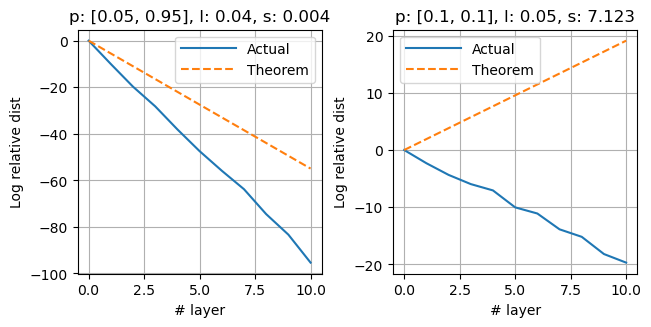

In [11]:
fig, axs = plt.subplots(1, 2, layout='constrained')
axs[0].plot(n_layers_list, E_list, label='Actual')
axs[0].plot(n_layers_list, Therorem_bound, label='Theorem', ls='--')
axs[0].set_xlabel('# layer')
axs[0].set_ylabel('Log relative dist')
axs[0].grid(True)
axs[0].legend(handlelength=4)
axs[0].set_title('p: ' + str(p_ER) + ', l: ' + str(np.round(Lambda,2)) 
                 + ', s: ' 
                 + str(np.round(np.mean(s_max_list), 3)) )
axs[0].set_box_aspect(1)

low_p = 0.1; high_p = 0.95
p_ER = [low_p, low_p]
Norm_coeff = 2.5
E_list, Therorem_bound, Lambda, s_max_list = Oversmoothing_analysis(N, p_ER, 
                                                                                k, t, 
                                                                                n_layers_list, 
                                                                                Norm_coeff,
                                                                                Fea, X0)

#%%
# np.savez('Oversmoothing_Results_2.npz', array1=E_list, array2=Therorem_bound, array3=Lambda, array4=s_max_list)
# a = np.load('Oversmoothing_Results_2.npz')
# E_list = a['array1']
# Therorem_bound = a['array2']
# Lambda = a['array3']
# s_max_list = a['array4']

axs[1].plot(n_layers_list, E_list, label='Actual')
axs[1].plot(n_layers_list, Therorem_bound, label='Theorem', ls='--')
axs[1].set_xlabel('# layer')
axs[1].set_ylabel('Log relative dist')
axs[1].grid(True)
axs[1].legend(handlelength=4)
axs[1].set_title('p: ' + str(p_ER) + ', l: ' + str(np.round(Lambda,2)) 
                 + ', s: ' 
                 + str(np.round(np.mean(s_max_list), 3)) )
axs[1].set_box_aspect(1)

# plt.savefig('OverSmoothing.png')
# plt.savefig("OverSmoothing.pdf")
# plt.savefig("OverSmoothing.eps")
# plt.savefig("OverSmoothing.svg")
plt.show()